# Unconstrained convex optimization

*Selected Topics in Mathematical Optimization: 2017-2018*

**Michiel Stock** ([email](michiel.stock@ugent.be))

![](Figures/logo.png)

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from teachingtools import blue, green, yellow, orange, red, black
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Motivation

In this chapter we will study unconstrained convex problems, i.e. problems of the form

$$
\min_\mathbf{x}\, f(\mathbf{x})\,,
$$

in which $f$ is *convex*. Convex optimization problems are well understood. Their most attractive property is that when a minimizer exists, the minimizer is the unique global minimizer.

Most convex optimization problems do not have a closed-form solution, with the quadratic problems of the previous chapters as a notable exception. We will hence again have to resort to descent methods to find an (arbitrary accurate) approximate solution.

<div class="notes" style="color:crimson;">
notes:
</div>

## Convex sets and functions

### Convex set

> **In words**: a set $\mathcal{C}$ is called *convex* if the line segment between any two points in $\mathcal{C}$ also lies in $\mathcal{C}$.

> **In symbols**:  a set $\mathcal{C}$ is called *convex* if, for any $\mathbf{x}, \mathbf{x}' \in \mathcal{C}$ and any $\theta \in [0, 1]$, it holds that $\theta \mathbf{x} + (1 - \theta) \mathbf{x}' \in \mathcal{C}$.

![Some convex (A & B) and non-convex sets (B & D).](Figures/convex_sets.png)

### Convex functions

> **In words**:  a function $f$ is *convex* if the line segment between $(\mathbf{x}, f(\mathbf{x}))$ and $(\mathbf{x}', f (\mathbf{x}'))$ lies above the graph of $f$.

> **In symbols**: a function $f : \mathbb{R}^n\rightarrow \mathbb{R}$ is *convex* if
> - dom($f$) is convex
> - for any $\mathbf{x}, \mathbf{x}' \in \text{dom}(f)$ and any $\theta \in [0, 1]$, it holds that $f(\theta \mathbf{x} + (1-\theta)\mathbf{x}') \leq\theta f(\mathbf{x}) +(1-\theta)f(\mathbf{x}')$.

![A line connecting two points of a convex function always lies above the function.](Figures/convex_function_illustration.png)

![Some convex (A & C) and non-convex functions (B).](Figures/convex_functions.png)

From the definition, it follows that:

- If the function is differentiable, then $f(\mathbf{x})\geq f(\mathbf{x}')+\nabla f(\mathbf{x}')^\top(\mathbf{x}-\mathbf{x}')$ for all $\mathbf{x}$ and $\mathbf{x}' \in \text{dom}(f)$. **The first-order Taylor approximation is a global underestimator of $f$.**
- If the function is twice differentiable, then $\nabla^2 f(\mathbf{x})\succeq 0$ for any $\mathbf{x}\in\text{dom}(f)$.

Convex functions frequently arise:

- If $f$ and $g$ are both convex, then $m(x)=\max(f(x), g(x))$ and $h(x)=f(x)+g(x)$ are also convex.
- If $f$ and $g$ are convex functions and $g$ is non-decreasing over a univariate domain, then $h(x)=g(f(x))$ is convex. Example: $e^{f(x)}$ is convex if $f({x})$ is convex.

Note, the convexity of expected value in probability theory gives rise to *Jensen's inequality*. For any convex function $\varphi$, if holds that
$$
\varphi(\mathbb{E}[X]) \leq\mathbb{E}[\varphi(X)]\,.
$$

This implies for example that the square of an expected value of quantity is never greater than the expected square of that quantity.

### Strongly convex functions

> **In words**: a function $f$ is called *strongly convex* if it is at least as convex as a quadratic function.

> **In symbols**: a $f$ is called *strongly $m$-convex* (with $m>0$) if the function $f_m(\mathbf{x}) = f(\mathbf{x}) - \frac{m}{2}||\mathbf{x}||_2$ is convex.

If the first- and second order derivatives exists, a strongly $m$-convex satisfies:

- $f(\mathbf{x}') \geq f(\mathbf{x}) + \nabla f(\mathbf{x})^\top (\mathbf{x}'-\mathbf{x}) + \frac{m}{2}||\mathbf{x}'-\mathbf{x}||_2$
- $\nabla^2 f(\mathbf{x})-mI\succeq 0$ (all eigenvalues of the Hessian are greater than $m$)

If a function is $m$-strongly convex, this also implies that there exists an $M>m$ such that

$$
\nabla^2 f(\mathbf{x}) \preceq MI\,.
$$

Stated differently, for strongly convex functions the exist both a quadratic function with a smaller as well as a lower local curvature.

![For strongly convex functions, it holds that there are two constants $m$ and $M$ such that $mI\preceq\nabla^2 f(\mathbf{x}) \preceq MI$. ](Figures/strong_convexity.png)



## Toy examples

To illustrate the algorithms, we introduce two toy functions to minimize:

- simple quadratic problem:
$$
f(x_1, x_2) = \frac{1}{2} (x_1^2 +\gamma x_2^2)\,,
$$
where $\gamma$ determines the condition number.
- a non-quadratic function:
$$
f(x_1, x_2) = \log(e^{x_1 +3x_2-0.1}+e^{x_1 -3x_2-0.1}+e^{-x_1 -0.1})\,.
$$

In [8]:
from teachingtools import plot_contour, add_path  # functions for showing the toy examples
from teachingtools import quadratic, grad_quadratic, hessian_quadratic
from teachingtools import nonquadratic, grad_nonquadratic, hessian_nonquadratic

Text(0.5,1,'Non-quadratic')

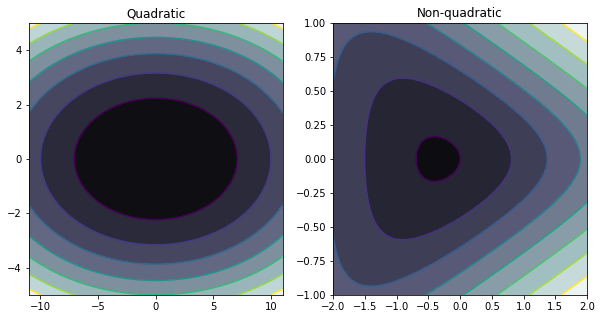

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
plot_contour(quadratic, (-11, 11), (-5, 5), ax1)
ax1.set_title('Quadratic')
plot_contour(nonquadratic, (-2, 2), (-1, 1), ax2)
ax2.set_title('Non-quadratic')

## General descent methods (recap)

Convex functions are usually minimized using descent methods. Again, line search is often used as a subroutine.

The outline of a general descent algorithm is given in the following pseudocode.

> **input** starting point $\mathbf{x}\in$ **dom** $f$.
>
> **repeat**
>
>>    1. Determine a descent direction $\Delta \mathbf{x}$.
>>    2. *Line seach*. Choose a step size $t>0$.
>>    3. *Update*. $\mathbf{x}:=\mathbf{x}+t\Delta \mathbf{x}$.
>
> **until** stopping criterion is satisfied.
>
> **output** $\mathbf{x}$


The specific optimization algorithms are hence determined by:

- method for determining the search direction $\Delta \mathbf{x}$, this is almost always based on the gradient of $f$
- method for choosing the step size $t$, may be fixed or adaptive
- the criterion used for terminating the descent, usually the algorithm stops when the improvement is smaller than a predefined value

## Backtracking line search

For quadratic optimization, as covered in Chapter 1, the optimal step size could be computed in closed form. In the general case, only an approximately optimal step size is used.

### Exact line search

As a subroutine of the general descent algorithm a line search has to be performed. A value for $t$ is chosen to minimize $f$ along the ray $\{\mathbf{x}+t\Delta \mathbf{x} \mid t\geq0\}$:

$$
t = \text{arg min}_{s\geq0}\ f(\mathbf{x}+s\Delta \mathbf{x})\,.
$$

Exact line search is used when the cost of solving the above minimization problem is small compared to the cost of calculating the search direction itself. This is sometimes the case when an analytical solution is available.

### Inexact line search

Often, the descent methods work well when the line search is done only approximately. This is because the computational resources are better spent to performing more *approximate* steps in the different directions because the direction of descent will change anyway.

Many methods exist for this, we will consider the *backtracking line search* (BTLS), described by the following pseudocode.

> **input** starting point $\mathbf{x}\in$ **dom** $f$, descent direction $\Delta \mathbf{x}$, gradient $\nabla f(\mathbf{x})$,  $\alpha\in(0,0.5)$ and $\beta\in(0,1)$.
>
> $t:=1$
>
>**while** $f(\mathbf{x}+t\Delta \mathbf{x}) > f(x) +\alpha t \nabla f(\mathbf{x})^\top\Delta \mathbf{x}$
>
>>    $t:=\beta t$
>
>
>**output** $t$

The backtracking line search has two parameters:

- $\alpha$: fraction of decrease in f predicted by linear interpolation we accept
- $\beta$: reduction of the step size in each iteration of the BLS
- typically, $0.01 \leq \alpha \leq 0.3$ and $0.1 \leq \beta < 1$

![Illustration of the backtracking line search.](Figures/btls.png)

**Assignment 1**

1. Complete the code for the backtracking line search
2. Use this function find the step size $t$ to (approximately) minimize $f(x) = x^2 - 2x - 5$ starting from the point $0$. Choose a $\Delta x=10$.

In [47]:
def backtracking_line_search(f, x0, Dx, grad_f, alpha=0.05, beta=0.6):
    '''
    Uses backtracking for finding the minimum over a line.
    Inputs:
        - f: function to be searched over a line
        - x0: initial point
        - Dx: direction to search
        - grad_f: gradient of f
        - alpha
        - beta
    Output:
        - t: suggested stepsize
    '''
    t = 1
    while f(x0+t*Dx) > f(x0) + alpha*t*np.sum(grad_f(x0)*Dx):
        t *= beta 
    return t

In [60]:
from unconstrained import backtracking_line_search

In [28]:
function = lambda x : x**2 - 2*x - 5
gradient_function = lambda x : 2*x -2
backtracking_line_search(function, 0, 10, gradient_function)

0.1296

**Question 1**

Describe the effect of $\alpha$, $\beta$ and $\Delta \mathbf{x}$. How can you perform a more precise search?

YOUR ANSWER HERE

## Gradient descent

A natural choice for the search direction is the negative gradient: $\Delta \mathbf{x} = -\nabla f(\mathbf{x})$. This algorithm is called the *gradient descent algorithm*.

### General gradient descent algorithm

>**input** starting point $\mathbf{x}\in$ **dom** $f$.
>
>**repeat**
>
>>    1. $\Delta \mathbf{x} := -\nabla f(\mathbf{x})$.
>>    2. *Line seach*. Choose a step size $t$ via exact or backtracking line search.
>>    3. *Update*. $\mathbf{x}:=\mathbf{x}+t\Delta \mathbf{x}$.
>
>**until** stopping criterion is satisfied.
>
>**output** $\mathbf{x}$

The stopping criterion is usually of the form $||\nabla f(\mathbf{x})||_2 \leq \nu$.

### Convergence analysis

The notion of strongly convexity allows us to bound the function $f$ by two quadratic functions. As such we can reuse the convergence analysis of the previous chapter.

If $f$ is strongly convex (constants $m$ and $M$ exist such that $mI\prec \nabla^2 f(\mathbf{x})\prec MI$), it holds that $f(\mathbf{x}^{(k)}) - p^*\leq \varepsilon$ after at most
$$
\frac{\log((f(\mathbf{x}^{(0)}) - p^*)/\varepsilon)}{\log(1/c)}
$$
iterations, where $c =1-\frac{m}{M}<1$.

We conclude:

- The number of steps needed for a given quality is proportional to the logarithm of the initial error.
- To increase the accuracy with an order of magnitude, only a few more steps are needed.
- Convergence is again determined by the *condition number* $M/m$. Note that for large condition numbers: $\log(1/c)=-\log(1-\frac{m}{M})\approx m/M$, so the number of required iterations increases linearly with increasing $M/m$.


**Assignment 2**

1. Complete the implementation of the gradient descent method.
2. Plot the paths for the two toy problems. Use $\mathbf{x}^{(0)}=[10,1]^\top$ for the quadratic function and $\mathbf{x}^{(0)}=[-0.5,0.9]^\top$ for the non-quadratic function as starting points.
3. Analyze the convergence.

In [80]:
def gradient_descent(f, x0, grad_f,  alpha=0.05, beta=0.6,
      nu=1e-3, trace=False):
    '''
    General gradient descent algorithm.
    Inputs:
        - f: function to be minimized
        - x0: starting point
        - grad_f: gradient of the function to be minimized
        - alpha: parameter for btls
        - beta: parameter for btls
        - nu: parameter to determine if the algorithm is converged
        - trace: (bool) store the path that is followed?
    Outputs:
        - xstar: the found minimum
        - x_steps: path in the domain that is followed (if trace=True)
        - f_steps: image of x_steps (if trace=True)
    '''
    x = x0  # initial value
    xPrev = x
    if trace: x_steps = [x0.copy()]
    if trace: f_steps = [f(x0)]
    while True:
        Dx = -grad_f(x)
        if np.linalg.norm(grad_f(x)) <= nu:
            break  # converged
        t = backtracking_line_search(f,x, Dx, grad_f,alpha,beta)
        x += t*Dx
        if trace: x_steps.append(x.copy())
        if trace: f_steps.append(f(x))
    if trace: return x, x_steps, f_steps
    else: return x

Number of steps quadratic function: 64
Number of steps non-quadratic function: 27


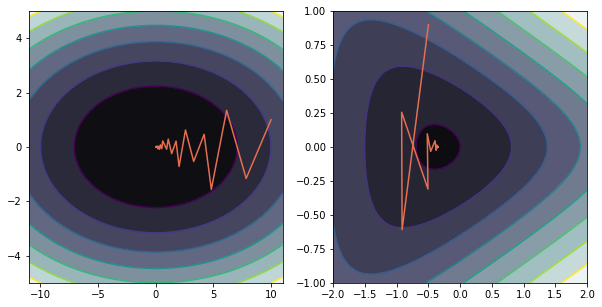

In [48]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

plot_contour(quadratic, (-11, 11), (-5, 5), ax1)
plot_contour(nonquadratic, (-2, 2), (-1, 1), ax2)

xstar_q, x_steps_q, f_steps_q = gradient_descent(quadratic, np.array([[10.0], [1.0]]), 
                                                 grad_quadratic, nu=1e-5, trace=True)
add_path(ax1, x_steps_q, red)

print('Number of steps quadratic function: {}'.format(len(x_steps_q) - 1))

xstar_nq, x_steps_nq, f_steps_nq = gradient_descent(nonquadratic, np.array([[-0.5], [0.9]]),
                                                    grad_nonquadratic, nu=1e-5, trace=True)
add_path(ax2, x_steps_nq, red)

print('Number of steps non-quadratic function: {}'.format(len(f_steps_nq) - 1))

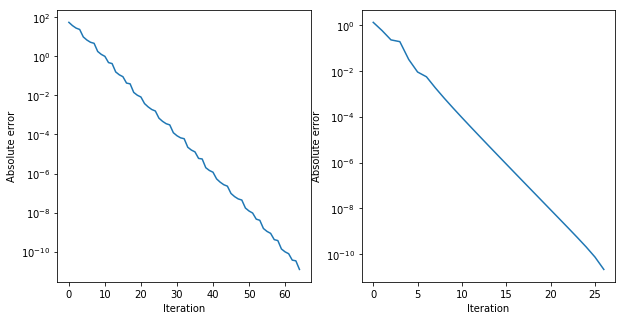

In [49]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.plot(np.abs(f_steps_q))
ax1.semilogy()
ax2.plot(np.abs(f_steps_nq[:-1] - f_steps_nq[-1]))  # error compared to last step
ax2.semilogy()

for ax in (ax1, ax2):
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Absolute error')

**Describe the convergence**

YOUR ANSWER HERE

Let us assess the effect of the hyperparameters of $\alpha$ and $\beta$ of the inexact line search.

In [53]:
alphas = np.linspace(0.01, 0.3, num=10)  # alphas to explore
betas = np.linspace(0.01, 0.99, num=15)  # betas to explore

steps_to_convergence = np.zeros((len(alphas), len(betas)))

for i, alpha in enumerate(alphas):
    for j, beta in enumerate(betas):
        xstar_q, x_steps_q, f_steps_q = gradient_descent(nonquadratic,
                                                np.array([[10.0], [1.0]]), 
                                                 grad_nonquadratic, nu=1e-5, trace=True,
                                                alpha=alpha, beta=beta)
        steps_to_convergence[i, j] = len(f_steps_q) - 1

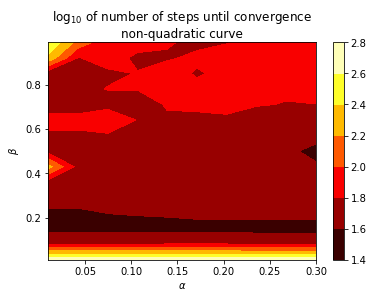

In [54]:
A, B = np.meshgrid(alphas, betas)
fig, ax = plt.subplots()

cs = ax.contourf(A,B,  np.log10(steps_to_convergence).T, cmap='hot')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.set_title('$\log_{10}$ of number of steps until convergence\nnon-quadratic curve')
cbar = fig.colorbar(cs)

**Describe the effect of $\alpha$, $\beta$.**

YOUR ANSWER HERE

Furthermore let us see what the effect is of the condition number on the number of steps until convergence. We will explore this for the quadratic function.

In [ ]:
condition_numbers = np.logspace(0, 3, num=25)
steps_to_convergence = np.zeros_like(condition_numbers)

for i, gamma in enumerate(condition_numbers):
    xstar_q, x_steps_q, f_steps_q = gradient_descent(lambda x:quadratic(x, gamma=gamma),
                                                     np.array([[10.0], [1.0]]), 
                                                 lambda x:grad_quadratic(x, gamma=gamma),
                                                     nu=1e-5, trace=True)
    steps_to_convergence[i] = len(f_steps_q) - 1  # number of steps

In [ ]:
fig, ax = plt.subplots()
ax.plot(condition_numbers, steps_to_convergence)
ax.loglog()
ax.set_ylabel('Number of steps\nuntil convergence')
ax.set_xlabel('Condition number')

**Describe the effect of the condition number.**

YOUR ANSWER HERE

## Steepest descent

Optimize the first-order Taylor approximation of a function:

$$
f(\mathbf{x}+\mathbf{v}) \approx \hat{f}(\mathbf{x}+\mathbf{v}) =f(\mathbf{x}) +\nabla f(\mathbf{x})^\top \mathbf{v}\,.
$$

The linear approximation $\hat{f}$ can be made arbitrary negative if we can freely choose $\mathbf{v}$! We have to constrain the *norm* of $\mathbf{v}$.

### Vector norms

A norm on $\mathbb{R}^n$ is a function $||\cdot||:\mathbb{R}^n\rightarrow \mathbb{R}$ with the following properties:

- $||\mathbf{x}||>0$, for any $\mathbf{x}\in\mathbb{R}^n$
- $||\mathbf{x}+\mathbf{y}|| \leq ||\mathbf{x}||+||\mathbf{y}||$, for any $\mathbf{x}, \mathbf{y}\in\mathbb{R}^n$
- $||\lambda \mathbf{x}|| = |\lambda|\, ||\mathbf{x}||$ for any $\lambda \in\mathbb{R}$ and any $\mathbf{x}\in\mathbb{R}^n$
- $||\mathbf{x}||=0$ if and only if $\mathbf{x}=0$

For example, for any $\mathbf{x}\in\mathbb{R}^n$ and $p\leq 1$:
$$
||\mathbf{x}||_p = \left(\sum_{i=1}^n |x_i|^p\right)^\frac{1}{p}\,.
$$

$||\cdot||_1$ is often called the $L_1$ norm and $||\cdot||_2$ the $L_2$ norm.

Consider $P\in \mathbb{R}^{n\times n}$ such that $P\succ 0$. The  corresponding *quadratic norm*:
$$
||\mathbf{z}||_P = (\mathbf{z}^\top P\mathbf{z})^\frac{1}{2}=||P^\frac{1}{2}\mathbf{z}||_2\,.
$$
The matrix $P$ can be used to encode prior knowledge about the scales and dependencies in the space that we want to search.

### Dual norm

Let $|| \cdot ||$ be a norm on $\mathbb{R}^n$. The associated dual norm:
$$
||\mathbf{z}||_*=\sup_{\mathbf{x}} \{\mathbf{z}^\top\mathbf{x}\mid ||\mathbf{x}||\leq 1\}\,.
$$

Examples:

- The dual norm of $||\cdot||_1$ is $||\cdot||_\infty$
- The dual norm of $||\cdot||_2$ is $||\cdot||_2$
- The dual norm of $||\cdot||_P$ is defined by $||\mathbf{z}||_*=||P^{-\frac{1}{2}}\mathbf{z}||$

### Steepest descent directions

**Normalized steepest descent direction**:

$$
\Delta x_\text{nsd} = \text{arg min}_\mathbf{v}\, \{\nabla f(\mathbf{x})^T \mathbf{v} \mid ||\mathbf{v}||\leq 1 \}\,.
$$

**Unnormalized steepest descent direction**:

$$
\Delta x_\text{sd} = ||\nabla f(\mathbf{x})||_\star \Delta x_\text{nsd} \,.
$$

Note that we have
$$
\nabla f(\mathbf{x})^\top \Delta x_\text{sd} = ||\nabla f(\mathbf{x})||_\star \nabla f(\mathbf{x})^\top\Delta x_\text{nsd} = -||\nabla f(\mathbf{x})||^2_\star\,,
$$
so this is a valid descent method.

![Illustration of some descent directions based on different norms.](Figures/sd_gradients.png)

### Coordinate descent algorithm

Using the $L_1$ norm results in coordinate descent. For every iteration in this algorithm, we descent in the direction of the dimension where the absolute value of the gradient is largest.

>**input** starting point $\mathbf{x}\in$ **dom** $f$.
>
>**repeat**
>
>>    1. *Direction*. Choose $i$ such that $|\nabla f(\mathbf{x})_i|$ is maximal.
>>    2. *Choose direction*. $\Delta \mathbf{x} := -\nabla f(\mathbf{x})_i \mathbf{e}_i$
>>    3. *Line seach*. Choose a step size $t$ via exact or backtracking line search.
>>    4. *Update*. $\mathbf{x}:=\mathbf{x}+t\Delta \mathbf{x}$.
>
>**until** stopping criterion is satisfied.
>
>**output** $\mathbf{x}$

Here, $\mathbf{e}_i$ is the $i$-th basic vector.

The stopping criterion is usually of the form $||\nabla f(\mathbf{x})||_2 \leq \nu$.

Coordinate descent optimizes every dimension in turn, for this reason it is sometimes used in minimization problems which enforce sparseness (e.g. LASSO regression).

> *Optimizing one dimension at a time is usually a poor strategy. This is because different dimensions are often related.*

**Assignment 3**

1. Complete the implementation of the coordinate descent method.
2. Plot the paths for the two toy problems. Use the same stating points as before.
3. Analyze the convergence.

In [ ]:
from unconstrained import coordinate_descent

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
plot_contour(quadratic, (-11, 11), (-5, 5), ax1)
plot_contour(nonquadratic, (-2, 2), (-1, 1), ax2)

xstar_q, x_steps_q, f_steps_q = coordinate_descent(quadratic, np.array([[10.1], [1.0]]), 
                                                 grad_quadratic, nu=1e-5, trace=True)
add_path(ax1, x_steps_q, red)

print('Number of steps quadratic function: {}'.format(len(x_steps_q) - 1))

xstar_nq, x_steps_nq, f_steps_nq = coordinate_descent(nonquadratic, np.array([[-0.5], [0.9]]),
                                                    grad_nonquadratic, nu=1e-5, trace=True)
add_path(ax2, x_steps_nq, red)

print('Number of steps non-quadratic function: {}'.format(len(f_steps_nq) - 1))

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.plot(np.abs(f_steps_q))
ax1.semilogy()
ax2.plot(np.abs(f_steps_nq[:-1] - f_steps_nq[-1]))  # error compared to last step
ax2.semilogy()

for ax in (ax1, ax2):
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Absolute error')

**Describe the convergence of coordinate descent compared to gradient descent.**

YOUR ANSWER HERE

## Newton's method

### The Newton step

In Newton's method the descent direction is chosen as

$$
\Delta \mathbf{x}_\text{nt} = -(\nabla^2f(\mathbf{x}))^{-1} \nabla f(\mathbf{x})\,,
$$
which is called the *Newton step*.

If $f$ is convex, then $\nabla^2f(\mathbf{x})$ is positive definite and
$$
\nabla f(\mathbf{x})^\top \Delta \mathbf{\mathbf{x}}_\text{nt} \geq 0\,,
$$
hence the Newton step is a descent direction unless $\mathbf{x}$ is optimal.

This Newton step can be motivated in several ways.

**Minimizer of a second order approximation**

The second order Taylor approximation $\hat{f}$ of $f$ at $\mathbf{x}$ is

$$
f(\mathbf{x}+\mathbf{v})\approx\hat{f}(\mathbf{x}+\mathbf{v}) = f(\mathbf{x}) + \nabla f(\mathbf{x})^\top \mathbf{v} + \frac{1}{2} \mathbf{v}^\top \nabla^2 f(\mathbf{x}) \mathbf{v}\,
$$

which is a convex quadratic function of $\mathbf{v}$, and is minimized when $\mathbf{v}=\Delta \mathbf{x}_\text{nt}$.

This quadratic model will be particularly accurate when $\mathbf{x}$ is close to $\mathbf{x}^\star$.

**Steepest descent direction in Hessian norm**

The Newton step is the steepest descent step if a quadratic norm using the Hessian is used, i.e.
$$
||\mathbf{u}||_{\nabla^2f(\mathbf{x})}=(\mathbf{u}^\top\nabla^2f(\mathbf{x})\mathbf{u})^\frac{1}{2}\,.
$$

**Affine invariance of the Newton step**

> *A consistent algorithm should give the same results independent of the units in which quantities are measured.*  ~ Donald Knuth

The Newton step is independent of linear or affine changes of coordinates. Consider a non-singular $n\times n$ transformation matrix $T$. If we apply a coordinate transformation $\mathbf{x}=T\mathbf{y}$ and define $\bar{f}(\mathbf{y}) = f(\mathbf{x})$, then
$$
\nabla \bar{f}(\mathbf{y}) = T^\top\nabla f(\mathbf{x})\,,\quad \nabla^2 \bar{f}(\mathbf{y}) = T^\top\nabla^2f(\mathbf{x})T\,.
$$
As such it follows that
$$
\mathbf{x} + \Delta \mathbf{x}_\text{nt} = T (\mathbf{y} + \Delta \mathbf{y}_\text{nt})\,.
$$

**Questions 2**

Does scaling and rotation affect the working of gradient descent and coordinate descent?

### Newton decrement

The Newton decrement is defined as
$$
\lambda(\mathbf{x})  = (\nabla f(\mathbf{x})^\top\nabla^2 f(x)^{-1}\nabla f(\mathbf{x}))^{1/2}\,.
$$

This can be related to the quantity $f(\mathbf{x})-\inf_\mathbf{y}\ \hat{f}(\mathbf{y})$:
$$
f(\mathbf{x})-\inf_\mathbf{y}\ \hat{f}(\mathbf{y}) = f(\mathbf{x}) - \hat{f}(\mathbf{x} +\Delta \mathbf{x}_\text{nt}) = \frac{1}{2} \lambda(\mathbf{x})^2\,.
$$
Thus $\frac{1}{2} \lambda(\mathbf{x})^2$ is an estimate of $f(\mathbf{x}) - p^*$, based on the quadratic approximation of $f$ at $\mathbf{x}$.

### Pseudocode of Newton's algortihm

>**input** starting point $\mathbf{x}\in$ **dom** $f$.
>
>**repeat**
>
>>    1. Compute the Newton step and decrement $\Delta \mathbf{x}_\text{nt} := -\nabla^2f(\mathbf{x})^{-1} \nabla f(\mathbf{x})$; $\lambda^2:=\nabla f(\mathbf{x})^\top\nabla^2 f(\mathbf{x})^{-1}\nabla f(\mathbf{x})$.
>>    2. *Stopping criterion* **break** if $\lambda^2/2 \leq \epsilon$.
>>    3. *Line seach*. Choose a step size $t$ via exact or backtracking line search.
>>    4. *Update*. $\mathbf{x}:=\mathbf{x}+t\Delta \mathbf{x}_\text{nt}$.
>
>**output** $\mathbf{x}$

The above algorithm is sometimes called the *damped* Newton method, as it uses a variable step size $t$. In practice, using a fixed step also works well. Here, one has to consider the computational cost of using BTLS versus performing a few extra Newton steps to attain the same accuracy.


### Convergence analysis

Iterations in Newton’s method fall into two stages:

- *damped Newton phase* $(t < 1)$ until $||\nabla f(\mathbf{x})||_2 \leq \eta$
- *pure Newton phase* $(t = 1)$: quadratic convergence

After a sufficiently large number of iterations, the number of correct digits doubles at each iteration.

**Assignment 4**

1. Complete the code for Newton's method.
2. Find the minima of the two toy problems. Use the same starting points as for gradient descent.

In [73]:
def newtons_method(f, x0, grad_f, hess_f, alpha=0.3,
                beta=0.8, epsilon=1e-3, trace=False):
    '''
    Newton's method for minimizing functions.
    Inputs:
        - f: function to be minimized
        - x0: starting point
        - grad_f: gradient of the function to be minimized
        - hess_f: hessian matrix of the function to be minimized
        - alpha: parameter for btls
        - beta: parameter for btls
        - nu: parameter to determine if the algorithm is converged
        - trace: (bool) store the path that is followed?
    Outputs:
        - xstar: the found minimum
        - x_steps: path in the domain that is followed (if trace=True)
        - f_steps: image of x_steps (if trace=True)
    '''
    x = x0  # initial value
    if trace: x_steps = [x.copy()]
    if trace: f_steps = [f(x0)]
    while True:
        Dx = - np.linalg.solve(hess_f(x),grad_f(x))
        lambda_square = np.sum(grad_f(x)*-Dx)
        if lambda_square < epsilon:
            break  # converged
        t = backtracking_line_search(f, x, Dx, grad_f, alpha, beta)
        x += t*Dx
        if trace: x_steps.append(x.copy())
        if trace: f_steps.append(f(x))
    if trace: return x, x_steps, f_steps    
    else: return x

Number of steps quadratic function: 1
Number of steps non-quadratic function: 5


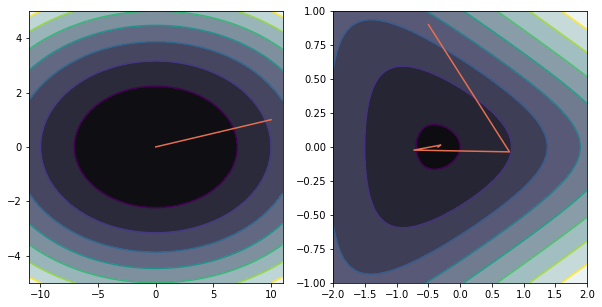

In [74]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
plot_contour(quadratic, (-11, 11), (-5, 5), ax1)
plot_contour(nonquadratic, (-2, 2), (-1, 1), ax2)

xstar_q, x_steps_q, f_steps_q = newtons_method(quadratic, np.array([[10.0], [1.0]]),grad_quadratic, hessian_quadratic, epsilon=1e-8, trace=True)
add_path(ax1, x_steps_q, red)

print('Number of steps quadratic function: {}'.format(len(x_steps_q) - 1))

xstar_nq, x_steps_nq, f_steps_nq = newtons_method(nonquadratic, np.array([[-0.5], [0.9]]),                         grad_nonquadratic, hessian_nonquadratic, epsilon=1e-8, trace=True)
add_path(ax2, x_steps_nq, red)

print('Number of steps non-quadratic function: {}'.format(len(x_steps_nq) - 1))

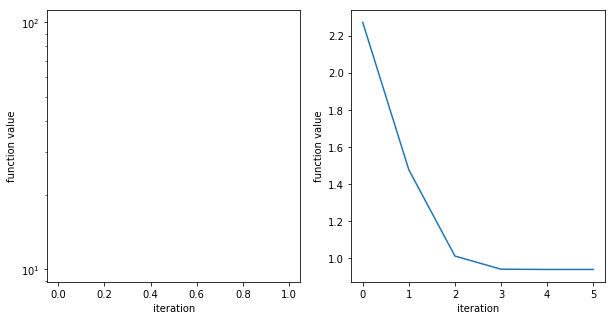

In [75]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.plot(f_steps_q)
ax1.semilogy()
ax2.plot(f_steps_nq)

for ax in (ax1, ax2):
    ax.set_xlabel('iteration')
    ax.set_ylabel('function value')

#### Effect of condtition number and rotations.

Below is an applet to demonstrate the effect of 1) changing the condition problem of the quadratic function and 2) rotating the function such that the axes of the ellipsis are no longer alligned with the coordinate axes. 

In [85]:
def show_condition(gamma, theta):
    quad_gamma = lambda x : quadratic(x, gamma, theta)
    x0 = np.array([[10.], [1.]])
    d_quad_gamma = lambda x : grad_quadratic(x, gamma, theta)
    dd_quad_gamma = lambda x : hessian_quadratic(x, gamma, theta)
    xstar_gd, x_steps_gd, f_steps_gd = gradient_descent(quad_gamma,
                                                    x0.copy(),
                                                     d_quad_gamma,
                                                     nu=1e-6, trace=True)

    xstar_nm, x_steps_nm, f_steps_nm = newtons_method(quad_gamma, x0.copy(),
                                                   d_quad_gamma, dd_quad_gamma, epsilon=1e-6, trace=True)
    fig, ax1 = plt.subplots(ncols=1, figsize=(10, 10))
    plot_contour(quad_gamma, [-10, 10], [-11, 11], ax1)
    add_path(ax1, x_steps_gd, blue, label='GD')
    add_path(ax1, x_steps_nm, green, label='NM')
    ax1.legend(loc=3)
    print('Gradient descent iterations: {}'.format(len(x_steps_gd) - 1 ))
    print('Newton\'s iterations: {}'.format(len(x_steps_nm) - 1))

In [86]:
from ipywidgets import interact, FloatSlider
interact(show_condition, gamma=FloatSlider(min=0.1, max=20.0, step=0.1, value=1),
            theta=FloatSlider(min=0, max=np.pi / 2, step=0.1, value=0))

A Jupyter Widget

<function __main__.show_condition>

**Describe the effect of the conditional number and rotations on the path of the different optimization algorithms.**

YOUR ANSWER HERE

### Scalability of the different algorithms

To study scaling towards higher dimensional problems, we minimize a function of the following form:

$$
f(\mathbf{x})  = \mathbf{x}^\top C \mathbf{x} - \sum_{i=1}^m \log(b_i - \mathbf{a}_i^\top\mathbf{x})
$$

with $C$ a positive-definite matrix and $b_i$ and $\mathbf{a}_i$ positive. 

We will optimize such a function in 20, 100 and 250 dimensions.

In [ ]:
from teachingtools import make_general_multidim_problem

In [ ]:
n_sizes = [20, 100, 250]
m_sizes = [100, 300, 1000]


fig, axes = plt.subplots(ncols=3, figsize=(20, 7))

for (n, m, ax) in zip(n_sizes, m_sizes, axes):
    f, g_f, h_f = make_general_multidim_problem(n, m)

    xstar_gd, x_steps_gd, f_steps_gd = gradient_descent(f, np.zeros((n, 1)), 
                                g_f, nu=1e-3, trace=True)

    xstar_cd, x_steps_cd, f_steps_cd = coordinate_descent(f, np.zeros((n, 1)), 
                                g_f, nu=1e-3, trace=True)
    
    xstar_newton, x_steps_newton, f_steps_newton = newtons_method(f, np.zeros((n, 1)), 
                                g_f, h_f, epsilon=1e-8, trace=True)
    
    ax.plot(np.abs(f_steps_gd - f_steps_gd[-1]), color = blue, label='Gradient desc.')
    ax.plot(np.abs(f_steps_cd - f_steps_cd[-1]), color = green, label='Coordinate desc.')
    ax.plot(np.abs(f_steps_newton - f_steps_newton[-1]), color = red, label='Newton method')
    
    ax.loglog()
    ax.legend(loc=0)
    ax.set_title('$n$={}, $m$={}'.format(n, m))
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Absolute error')

**Discuss the different algorithms with respect to their scalability.**

YOUR ANSWER HERE

### Summary Newton's method

- Convergence of Newton's algorithm is rapid and quadratic near $\mathbf{x}^\star$.
- Newton's algorithm is affine invariant, e.g. invariant to choice of coordinates or condition number.
- Newton's algorithm scales well with problem size. Computationally, computing and storing the Hessian might be prohibitive.
- The hyperparameters $\alpha$ and $\beta$  of BTLS do not influence the performance much.

## Quasi-Newton methods

Quasi-Newton methods try to emulate the success of the Newton method, but without the high computational burden of constructing the Hessian matrix every step. One of the most popular quasi-Newton algorithms is the *Broyden-Fletcher-Goldfarb-Shanno* (BFGS) algorithm. Here, the Hessian is approximated by a symmetric rank-one matrix.

## Numerical approximation of the gradient and Hessian

In many cases, there is no analytical expression for gradient and the Hessian. The finite difference method can motivate the following approximations for the gradient-vector product
$$
\nabla f(\mathbf{x})^\top\Delta\mathbf{x} \approx \frac{1}{2\epsilon} (f(\mathbf{x}+\epsilon\Delta\mathbf{x} ) - f(\mathbf{x}-\epsilon\Delta\mathbf{x} ))
$$
and the Hessian-vector product
$$
\nabla^2 f(\mathbf{x})^\top\Delta\mathbf{x} \approx \frac{1}{2\epsilon} (\nabla f(\mathbf{x}+\epsilon\Delta\mathbf{x} ) - \nabla f(\mathbf{x}-\epsilon\Delta\mathbf{x} ))\,
$$
with $\epsilon$ a small constant.

## Exercise: logistic regression

![Classification using logistic regression](Figures/classification.png)

Consider the following problem: we have a dataset of $n$ instances: $T=\{(\mathbf{x}_i, y_i)\mid i=1\ldots n\}$. Here $\mathbf{x}_i\in \mathbb{R}^p$ is a $p$-dimensional feature vector and $y_i\in\{0,1\}$ is a binary label. This is a binary classification problem, we are interested in predicting the label of an instance based on its feature description. The goal of logistic regression is to find a function $f(\mathbf{x})$ that estimates the conditional probability of $Y$:

$$
\mathcal{P}(Y=1 \mid \mathbf{X} = \mathbf{x})\,.
$$

We will assume that this function $f(\mathbf{x})$ is of the form
$$
f(\mathbf{x}) = \sigma(\mathbf{w}^\top\mathbf{x})\,,
$$
with $\mathbf{w}$ a vector of parameters to be learned and $\sigma(.)$ the logistic map:
$$
\sigma(t) = \frac{e^{t}}{1+e^{t}}=\frac{1}{1+e^{-t}}\,.
$$
It is easy to see that the logistic mapping will ensure that $f(\mathbf{x})\in[0, 1]$, hence $f(\mathbf{x})$ can be interpreted as a probability.

Note that
$$
\frac{\text{d}\sigma(t)}{\text{d}t} = (1-\sigma(t))\sigma(t)\,.
$$

To find the best weights that separate the two classes, we can use the following structured loss function:

$$
\mathcal{L;\lambda}(\mathbf{w})=-\sum_{i=1}^n[y_i\log(\sigma(\mathbf{w}^\top\mathbf{x}_i))+(1-y_i)\log(1-\sigma(\mathbf{w}^\top\mathbf{x}_i))] +\lambda \mathbf{w}^\top\mathbf{w}\,.
$$

Here, the first part is the cross entropy, which penalizes disagreement between the prediction $f(\mathbf{x}_i)$ and the true label $y_i$, while the second term penalizes complex models in which $\mathbf{w}$ has a large norm. The trade-off between these two components is controlled by $\lambda$, a hyperparameter. In the course *Predictive modelling* of Willem Waegeman it is explained that by carefully tuning this parameter one can obtain an improved performance. **In this project we will study the influence $\lambda$ on the convergence of the optimization algorithms.**

> **Warning**: for this project there is a large risk of numerical problems when computing the loss function. This is because in the cross entropy $0\log(0)$ should by definition evaluate to its limit value of $0$. Numpy will evaluate this as `nan`. Use the provided function `cross_entropy` which safely computes $-\sum_{i=1}^n[y_i\log(\sigma_i)+(1-y_i)\log(1-\sigma_i)]$.

![Toy example in two dimensions illustrating the loss function.](Figures/loss_logistic.png)

In [ ]:
from teachingtools import logistic_toy

In [ ]:
interact(logistic_toy, separation=FloatSlider(min=0, max=4, step=0.2, value=1), 
         log_lambda=FloatSlider(min=-5, max=5, step=1, value=1))

**Data overview**

Consider the data set in the file `BreastCancer.csv`. This dataset contains information about 569 female patients diagnosed with breast cancer. For each patient it was recorded wether the tumor was benign (B) or malignant (M), this is the response variable. Each tumor is described by 30 features, which encode some information about the tumor. We want to use logistic regression with regularization to predict wether a tumor is benign or malignant based on these features.

In [91]:
# pandas allows us to comfortably work with datasets in python
import pandas as pd

cancer_data = pd.read_csv('Data/BreastCancer.csv')  # load data
cancer_data.head()  # show first five rows

# extract response in binary encoding:
# 0 : B(enign)
# 1 : M(alignant)
binary_response = np.array(list(map(int, cancer_data.y == 'M')))

# extract feature matrix X
features = cancer_data.select(lambda colname : colname[0] == 'x',
      axis=1).values

# standarizing features
# this is needed for gradient descent to run faster
features -= features.mean(0)
features /= features.std(0)

**Assignments**

1. Derive and implement the loss function for logistic loss, the gradient and the Hessian of this loss function. These functions have as input the parameter vector $\mathbf{w}$, label vector $\mathbf{y}$, feature matrix $\mathbf{X}$ and $\lambda$. The logistic map and cross-entropy is already provided for you.
2. Consider $\lambda=0.1$, find the optimal parameter vector for this data using gradient descent, coordinate descent and Newton's method. Use standardized features. For each algorithm, give the number of steps the algorithm performed and the running time (use the [magic function](https://ipython.org/ipython-doc/3/interactive/magics.html) `%timeit`). Compare the loss for each of parameters obtained by the different algorithms.
3. How does regularization influence the optimization? Make a separate plot for gradient descent, coordinate descent and Newton's method with the the value of the loss as a function of the iteration of the given algorithm. Make separate the different methods and plot the convergence for $\lambda = [10^{-3}, 10^{-1}, 1, 10, 100]$. Does increased regularization make the optimization go faster or slower? Why does this make sense?

**Project assignment 1**

Complete the functions below.

In [ ]:
# COMPLETE THIS FOR QUESTION 1

logistic_map = lambda x : 1 / (1 + np.exp(-x))
cross_entropy = lambda l, p : - (l * np.log(p))[p>0]  # so that no nan is returned when p is very small

def logistic_loss(w, y, X, lamb):
    """
    Implement the logistic loss
    returns a scalar
    """
    return - np.sum(y * log(logistic_map(np.sum(w*x)))) + (1-y)
def grad_logistic_loss(w, y, X, lamb):
    """
    Implement the gradient of the logistic loss
    returns a column vector
    """
    return

def hess_logistic_loss(w, y, X, lamb):
    """
    Implement the Hessian of the logistic loss
    returns a matrix
    """
    return

In [87]:
# You can also use the implemented functions:
from logistic_regression import logistic_loss, grad_logistic_loss, hess_logistic_loss

In [88]:
# functions for first question

l_loss = lambda w : logistic_loss(w, binary_response, features, 0.1)
l_grad = lambda w : grad_logistic_loss(w, binary_response, features, 0.1)
l_hess = lambda w : hess_logistic_loss(w, binary_response, features, 0.1)

**Assignment 2**

Use gradient descent, coordinate descent and Newton's method to find the parameters of the logistic model ($\lambda=0.1$).

In [106]:
xstar_nm, x_steps_nm, f_steps_nm = newtons_method(l_loss,np.zeros(30),l_grad,l_hess,trace=True)

In [108]:
cancer_data.plot.scatter()

TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

NameError: name 'w' is not defined

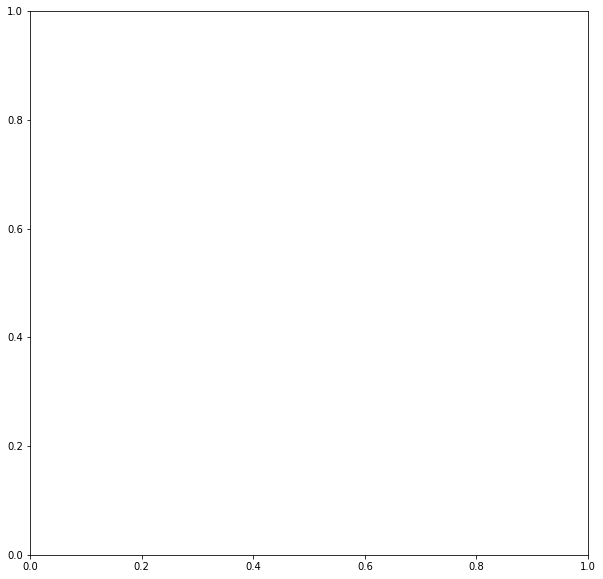

In [107]:
fig, ax1 = plt.subplots(ncols=1, figsize=(10, 10))
plot_contour((-11, 11), (-5, 5), ax1)

xstar_nm, x_steps_nm, f_steps_nm = newtons_method(l_loss,np.zeros(30),l_grad,l_hess,trace=True)


print('Number of steps quadratic function: {}'.format(len(x_steps_q) - 1))


DISCUSS THE DIFFERENCE IN RUNNING TIME

**Project assignment 3**

Make a plot for each of the four optimization method in which you show the convergence for $\lambda = [10^{-3}, 10^{-1}, 1, 10, 100]$.

DISCUSS THE DIFFERENCE IN CONVERGENCE

## References

Boyd, S. and Vandenberghe, L. *'Convex Optimization'*. Cambridge University Press (2004) [link](https://stanford.edu/~boyd/cvxbook/)